### Time Series Analysis

# FAANG IN 5

In [3]:
# imports
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [4]:
# open file called .env and read in our API
file = open('./.env')
api = file.read()

In [74]:
# Create a function that calls the API, creates a DataFrame with Stock information, and saves it in my folder as a
# csv if it does not exist. If it does exist, load up the cvs.

def get_stock(symbol):
    # Check if symbol exists as csv in current directory
    if isfile('./stock_data/' + symbol + '.csv'):
        # return our stored dataframe and with 'Date' as index
        stock = pd.read_csv('./stock_data/' + symbol + '.csv', index_col="Date")
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        print('File already exists...')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]
    # If it doesn't exit, get data and store it:
    else: 
        API_KEY = api
        r = requests.get(f'https://www.worldtradingdata.com/api/v1/history?symbol={symbol}&sort=newest&api_token={API_KEY}')
        # Use eval to disregard the type str
        data = eval(r.text)
        stock = pd.DataFrame(data['history'])
        # Transpose the df 
        stock = stock.T
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        # Make index name 'Date'
        stock.index.name = 'Date'
        # Creates a csv file with complete stock history
        stock.to_csv('./stock_data/' + symbol + '.csv')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]

In [75]:
# Call our function with desired stock (Facebook) to get stock information and store it in a variable
FB = get_stock('FB')

File already exists...


In [76]:
# Call our function with desired stock (Apple) to get stock information and store it in a variable
AAPL = get_stock('AAPL')

File already exists...


In [77]:
# Call our function with desired stock (Amazon) to get stock information and store it in a variable
AMZN = get_stock('AMZN')

File already exists...


In [78]:
# Call our function with desired stock (Netflix) to get stock information and store it in a variable
NFLX = get_stock('NFLX')

File already exists...


In [79]:
# Call our function with desired stock (Google) to get stock information and store it in a variable
GOOGL = get_stock('GOOGL')

File already exists...


In [124]:
MSFT = get_stock('MSFT')

File already exists...


In [81]:
# concat all of our stock DataFrames 
FAANG = pd.concat([FB, AAPL, AMZN, NFLX, GOOGL], axis=1)

In [82]:
# Get the sum of the stocks along the rows (axis=1)
FAANG = pd.DataFrame(FAANG['close'].dropna().sum(axis=1))

In [83]:
# Rename the column to 'close'
FAANG.columns = ['close']

In [84]:
FAANG.head()

,close
Date,
2012-05-18,638.04
2012-05-21,649.63
2012-05-22,635.97
2012-05-23,645.79
2012-05-24,640.90


In [85]:
# # Split our data up into months by the average closing price per month
FAANG = pd.DataFrame(FAANG.resample('MS').mean())

In [86]:
FAANG.head()

,close
Date,
2012-05-01,635.790000
2012-06-01,625.602857
2012-07-01,647.585238
2012-08-01,690.851739
2012-09-01,740.971053


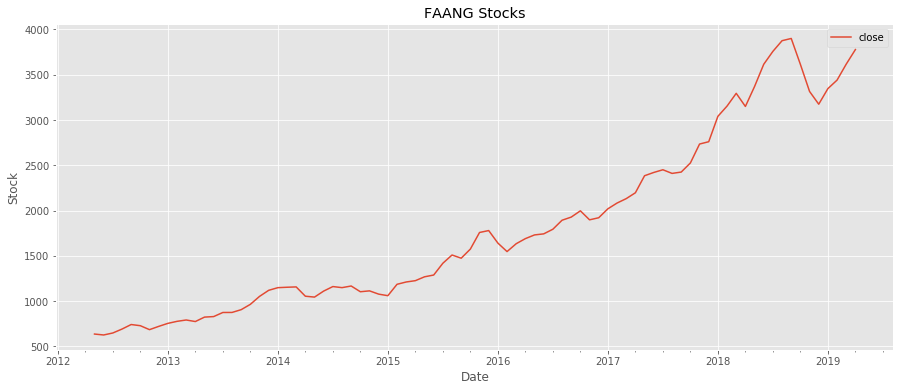

In [87]:
# plot FAANG stocks
FAANG.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Stock')
plt.title('FAANG Stocks')
plt.show()

In [88]:
# Determining rolling statistics
rolmean = FAANG.rolling(window=12).mean()
rolstd = FAANG.rolling(window=12).std()

In [89]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(FAANG['close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  2.284023
p-value                         0.998945
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


> 1. Our p-value should usually be less than or around 0.05 <br>
> 2. Our Critical Values should be greater than our Test Statistic

> Based on our Dickey-Fuller test above, both 1 and 2 are false so we can not reject the null hypothesis and we therefore say that our data is not stationary. 

In [21]:
# Create a function to return the rolling statistics as well as the Dickey-Fuller test based on a timeseries you give it
def stationarity_check(TS):

    # Calculate rolling statistics
    rolmean = TS.rolling(window = 12).mean()
    rolstd = TS.rolling(window = 12).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['close'], autolag='AIC') # change the passengers column as required 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

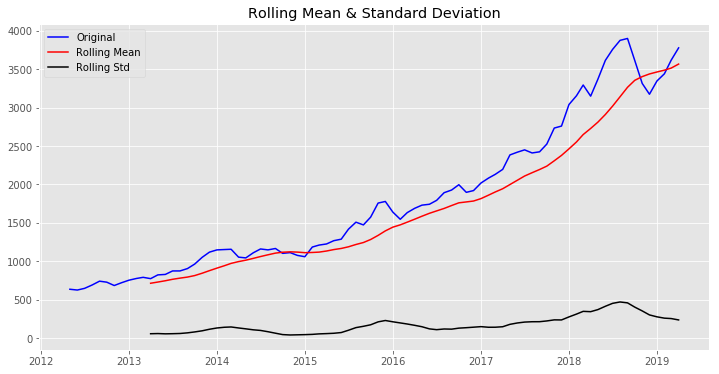

Results of Dickey-Fuller Test:
Test Statistic                  2.284023
p-value                         0.998945
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [22]:
stationarity_check(FAANG)

In [23]:
# Log transform the stock data
FAANG_log = np.log(FAANG)

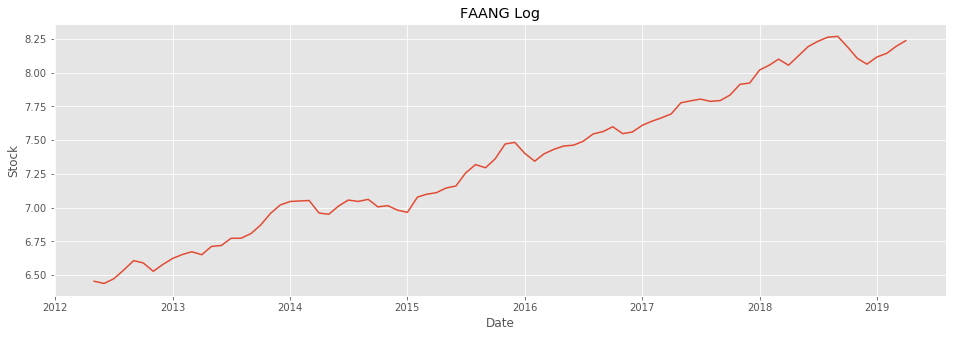

In [24]:
# plot the Log transformed data
plt.figure(figsize=(16,5))
plt.title('FAANG Log')
plt.xlabel('Date')
plt.ylabel('Stock')
plt.plot(FAANG_log)

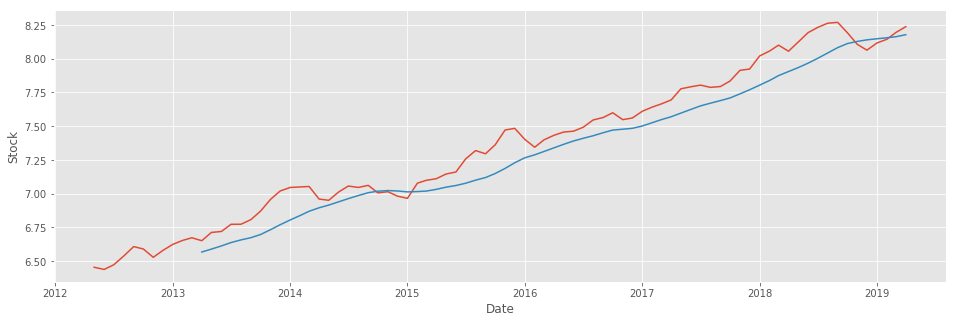

In [25]:
# Calculating moving average and moving std with a window of 12 and plot it
movingAverage = FAANG_log.rolling(window=12).mean()
movingSTD = FAANG_log.rolling(window=12).std()

plt.figure(figsize=(16,5))
plt.plot(FAANG_log)
plt.xlabel('Date')
plt.ylabel('Stock')
plt.plot(movingAverage)

In [26]:
# Difference of the Loged data and moving average
FAANG_log_moving_avg_diff = FAANG_log - movingAverage
FAANG_log_moving_avg_diff.dropna(inplace=True)

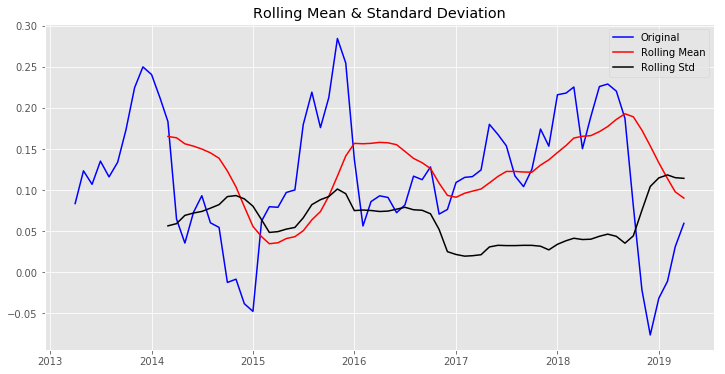

Results of Dickey-Fuller Test:
Test Statistic                 -3.424458
p-value                         0.010153
#Lags Used                      1.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [27]:
# Check to see if this data is now stationary
stationarity_check(FAANG_log_moving_avg_diff)

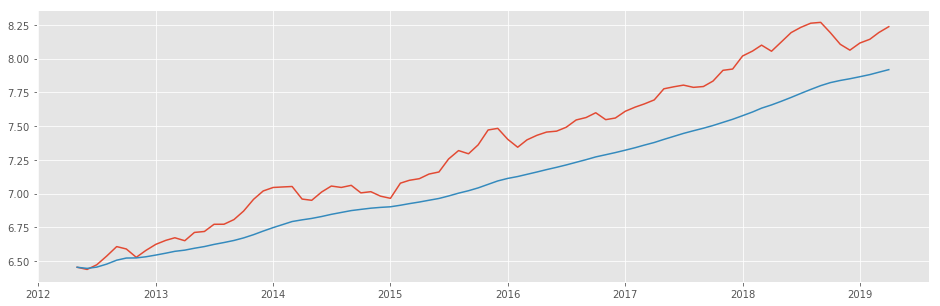

In [28]:
exponential_dwa = FAANG_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
plt.figure(figsize=(16,5))
plt.plot(FAANG_log)
plt.plot(exponential_dwa)

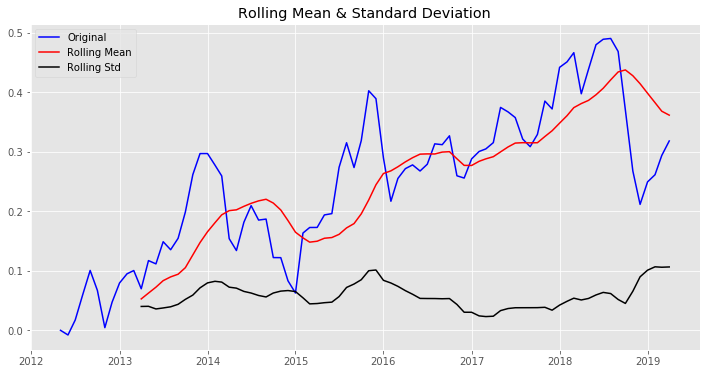

Results of Dickey-Fuller Test:
Test Statistic                 -2.562090
p-value                         0.101088
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [29]:
# Difference between Log data and exponential dwa data and check stationarity
FAANG_log_exponential_dwa_diff = FAANG_log - exponential_dwa
stationarity_check(FAANG_log_exponential_dwa_diff)

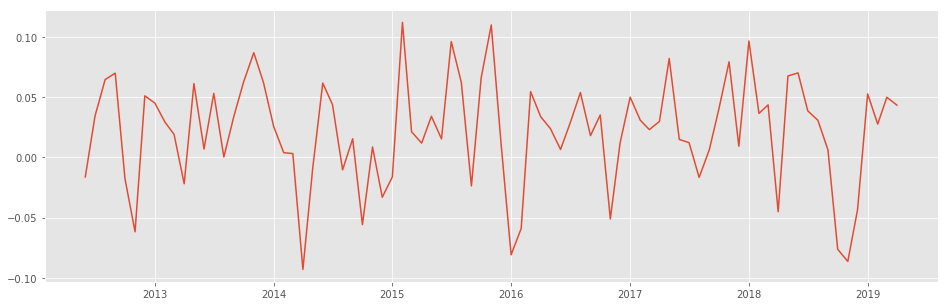

In [30]:
# Difference between log data and log data shifted by one 
FAANG_shift_diff = FAANG_log - FAANG_log.shift()
plt.figure(figsize=(16,5))
plt.plot(FAANG_shift_diff)

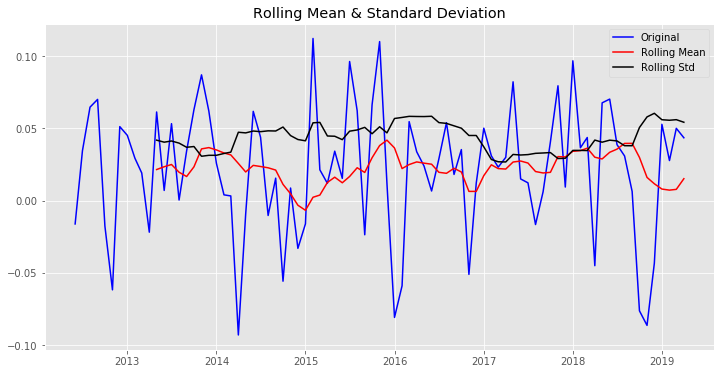

Results of Dickey-Fuller Test:
Test Statistic                -6.724101e+00
p-value                        3.424257e-09
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


In [31]:
# Check stationarity on the shifted difference data
FAANG_shift_diff.dropna(inplace=True)
stationarity_check(FAANG_shift_diff)

## Decomposing

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

>Seasonal: Patterns that repeat with a fixed period of time. For example, a stock may go up or down based on earnings or news; this would produce data with a seasonality of 7 days.

>Trend: The underlying trend of the metrics. A stock increasing in price should show a general trend that goes up.

>Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

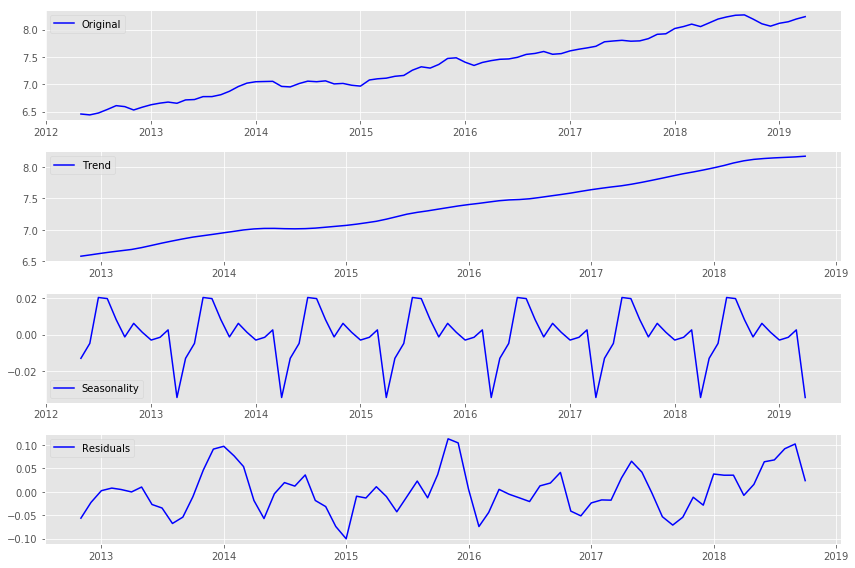

In [32]:
decomposition = sm.tsa.seasonal_decompose(FAANG_log)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(FAANG_log, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

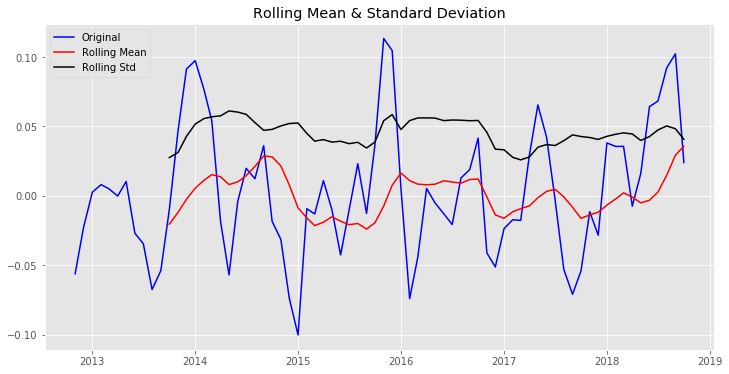

Results of Dickey-Fuller Test:
Test Statistic                 -5.438888
p-value                         0.000003
#Lags Used                      1.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [33]:
decompose = residual
decompose.dropna(inplace=True)
stationarity_check(decompose)

##  PACF and ACF
> The shaded area is 95% confidence interval.
>> Anything outside the colored region is statisitically significant <br>
>> Anything inside the colored region is not statistically significant

### ACF on Original Data

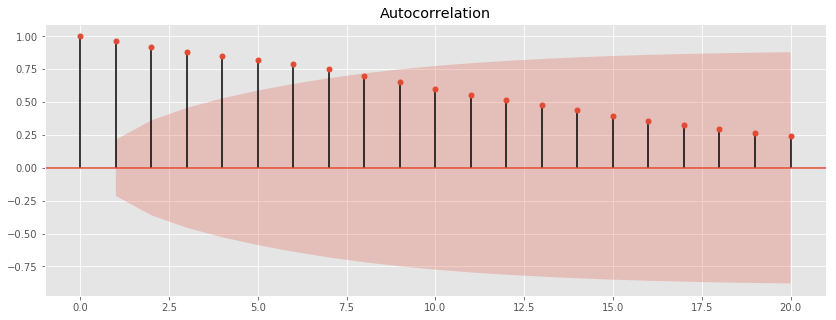

In [34]:
rcParams['figure.figsize'] = 14, 5

plot_acf(FAANG, lags = 20);

### ACF on Differenced Data

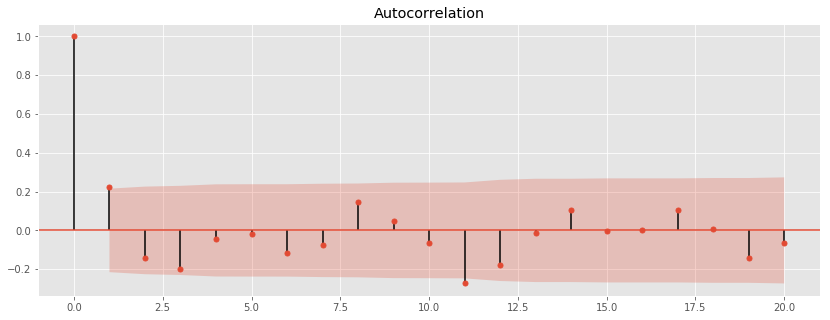

In [35]:
rcParams['figure.figsize'] = 14, 5

plot_acf(FAANG_shift_diff, lags = 20);

### PACF on Original Data

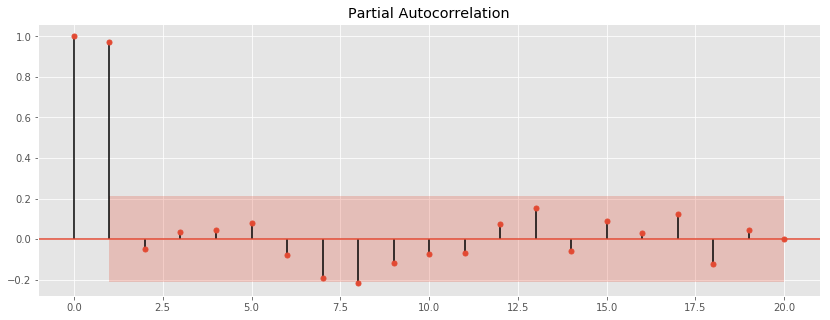

In [36]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(FAANG, lags = 20);

### PACF on Differenced Data

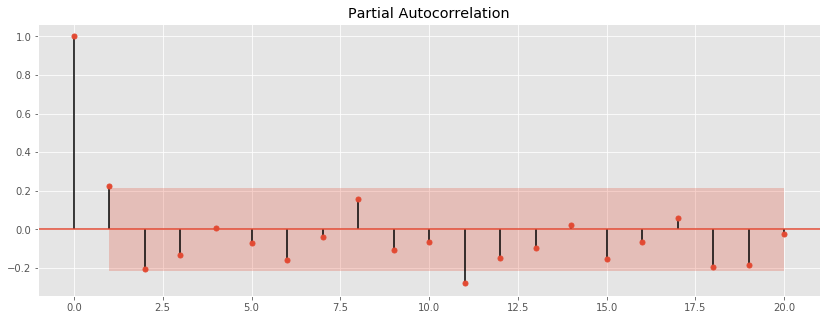

In [37]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(FAANG_shift_diff, lags = 20);

# ARIMA Modeling

>The first step towards fitting an ARIMA model is to find the values of ARIMA(p,d,q) that produce the desired output. Selection of these parameters requires domain expertise and time. We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters.

> 1. AR = p = autoregressive lags
> 2. MA = q = moving average
> 3. I = d = order of differentiation

In [38]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## AIC (Akaike Information Criterion)

> The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

> A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [91]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(FAANG,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1504.1321358028088
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1231.7274098514488
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1109.2389159661416
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =914.1825707703265
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1022.087060450287
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =983.8941610127519
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =901.660761392519
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =868.6489497334866
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1382.071872270854
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1130.7983821272894
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1013.812151098202
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =836.6328046888125
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =957.7066815193027
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =910.0785987397304
ARIMA (0, 0, 1) x

In [106]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           706.078
Name: 27, dtype: object

## Model Fitting

> In the simple grid example above, we identified the set of parameters that produced the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

In [93]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(FAANG,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_one = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1855      0.441      0.421      0.674      -0.679       1.050
ma.L1          0.2314      0.413      0.560      0.576      -0.579       1.042
ar.S.L12      -0.5642      0.283     -1.994      0.046      -1.119      -0.010
ma.S.L12      -0.2278      0.329     -0.693      0.488      -0.872       0.417
sigma2      1.214e+04   1829.627      6.634      0.000    8551.746    1.57e+04


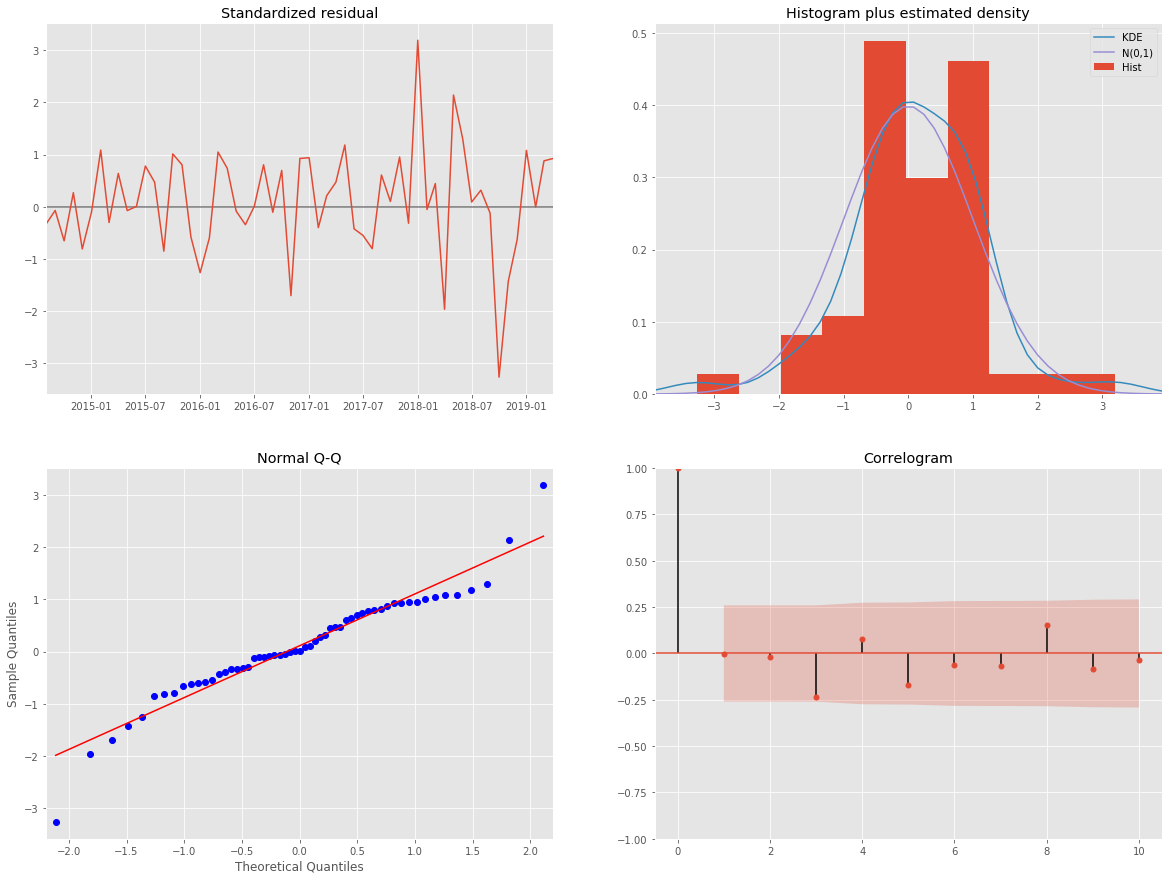

In [94]:
output.plot_diagnostics(figsize=(20, 15))
plt.show()

> Let's check for these assumptions from diagnostics plots.

> In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

> The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

> The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Validating the Model

In [95]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

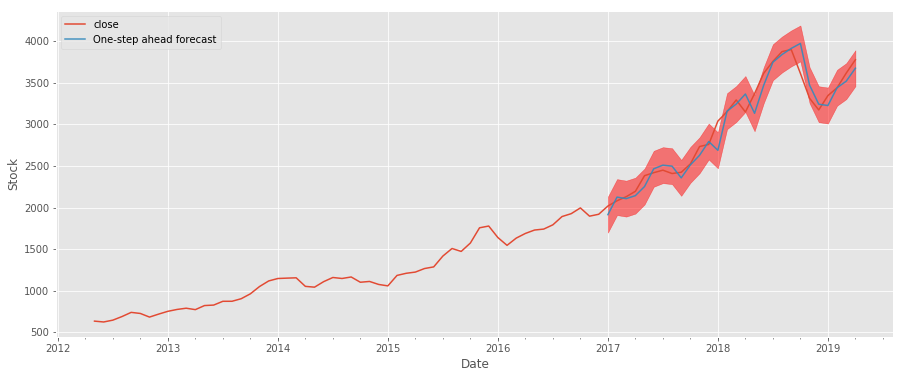

In [96]:
rcParams['figure.figsize'] = 15, 6

ax = FAANG['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Date')
ax.set_ylabel('Stock')
plt.legend()

plt.show()

## Mean Squared Error

In [97]:
# Get the Real and predicted values
y_forecasted = pred.predicted_mean
y_truth = FAANG['2017-01-01':]

# Calculate MSE
mse = mean_squared_error(y_truth, y_forecasted)

print(f'The Mean Squared Error of our forecasts is {(round(mse, 2))}.')

The Mean Squared Error of our forecasts is 18108.28.


## Root Mean Squared Error

In [98]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}.')

The Root Mean Squared Error of our forecasts is 134.57.


## Dynamic Forcasting

> We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [99]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

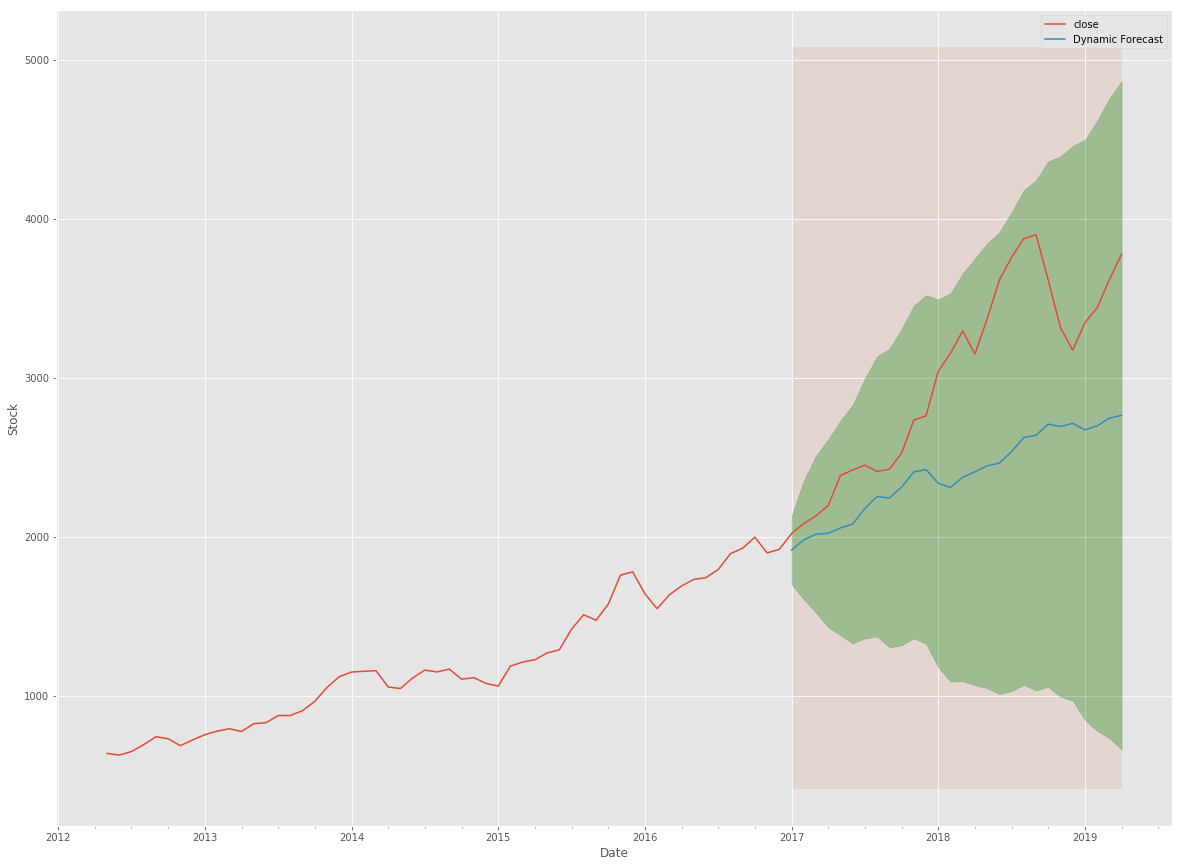

In [100]:
# Plot the dynamic forecast with confidence intervals.

ax = FAANG['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), y_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Stock')

plt.legend()
plt.show()

## Mean Squared Error

In [101]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = FAANG['2017-01-01':]

# Compute the mean square error
mse = mean_squared_error(y_truth, y_forecasted)
print(f'The Mean Squared Error of our forecasts is {(round(mse, 2))}.')

The Mean Squared Error of our forecasts is 512425.52.


## Root Mean Squared Error

In [102]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}.')

The Root Mean Squared Error of our forecasts is 715.84.


## Producing and Visualizing Forecasts

In [131]:
def get_prediction(stock):
    stock = get_stock(stock)
    stock = pd.DataFrame(stock['close'])
    stock = pd.DataFrame(stock.resample('MS').mean())
    print(stock.head())
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(stock,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(stock,
                                    order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'],
                                    seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output_one = ARIMA_MODEL.fit()

    # Get forecast 5 years in the future
    prediction = output.get_forecast(steps=50)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()

    # Plot future predictions with confidence intervals
    ax = stock.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock')

    plt.legend()
    plt.show()

File already exists...
               close
Date                
1986-03-01  0.096667
1986-04-01  0.102727
1986-05-01  0.110952
1986-06-01  0.111429
1986-07-01  0.102727


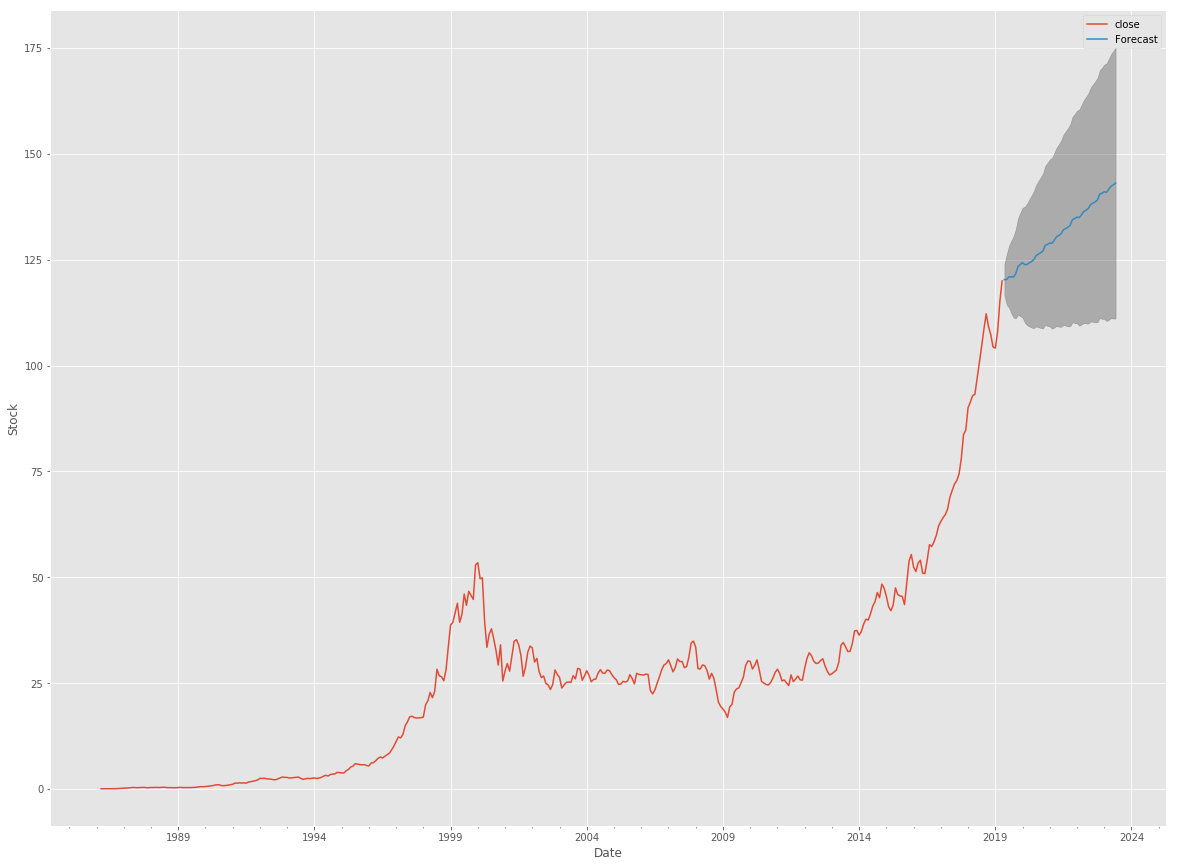

In [133]:
get_prediction('MSFT')

In [103]:
# Get forecast 5 years in the future
prediction = output.get_forecast(steps=50)
# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

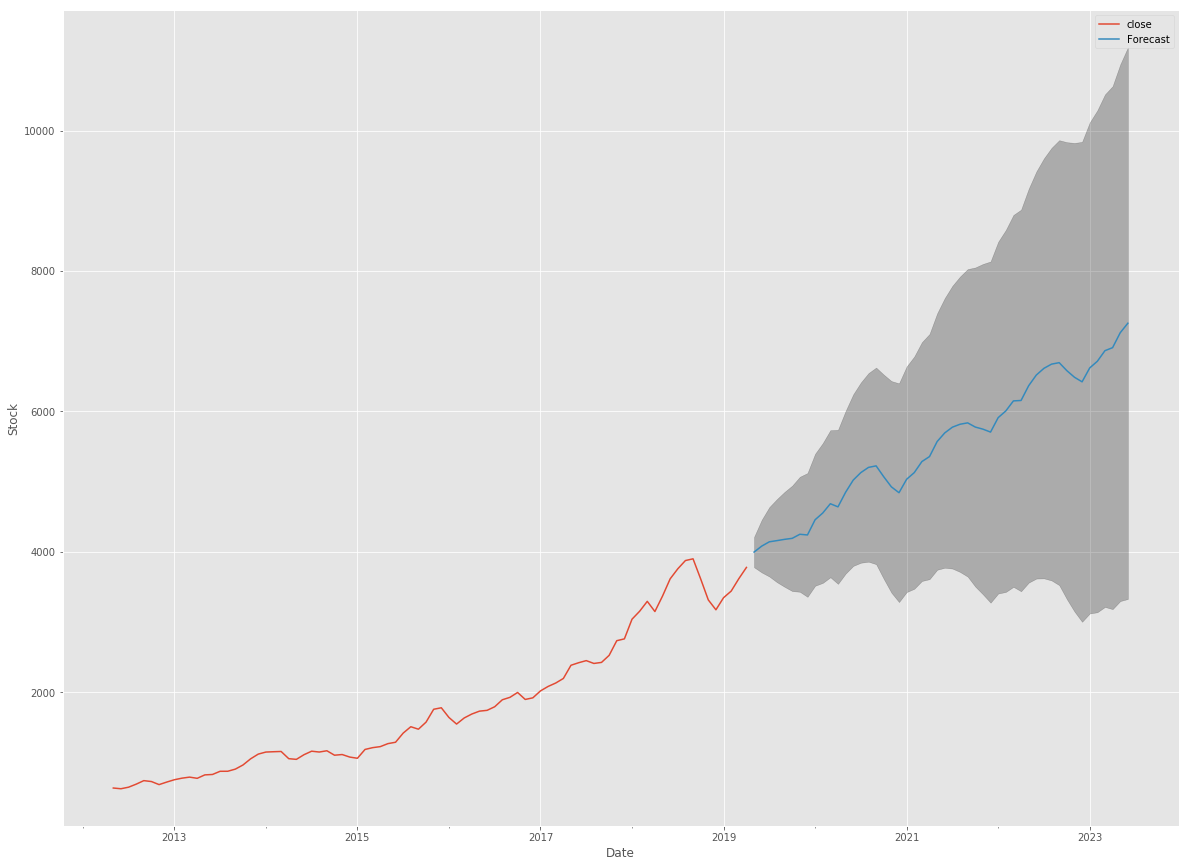

In [104]:
# Plot future predictions with confidence intervals

ax = FAANG.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Stock')

plt.legend()
plt.show()

## Facebook Prophet

In [53]:
from fbprophet import Prophet as proph

In [54]:
model = proph(interval_width=0.95,  weekly_seasonality=True, daily_seasonality=True)

In [134]:
# rename index column to 'ds' and 'close' column to 'y'
FAANG.rename(columns={'close':'y'}, inplace=True)
FAANG.index.names = ['ds']
FAANG.reset_index(inplace=True)

In [56]:
# Check to see if done correctly
FAANG.head()

,ds,y
0,2012-05-01,635.790000
1,2012-06-01,625.602857
2,2012-07-01,647.585238
3,2012-08-01,690.851739
4,2012-09-01,740.971053


In [57]:
model.fit(FAANG)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future_dates = model.make_future_dataframe(periods=48, freq='MS')
future_dates.tail()

,ds
127,2022-12-01
128,2023-01-01
129,2023-02-01
130,2023-03-01
131,2023-04-01


In [59]:
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-05-01,549.819743,302.511115,893.007984,549.819743,549.819743,41.778445,41.778445,41.778445,41.778445,41.778445,41.778445,0.0,0.0,0.0,591.598188
1,2012-06-01,572.424100,301.975924,909.170835,572.424100,572.424100,48.712312,48.712312,48.712312,48.712312,48.712312,48.712312,0.0,0.0,0.0,621.136412
2,2012-07-01,594.299285,370.254447,948.236738,594.299285,594.299285,66.158458,66.158458,66.158458,66.158458,66.158458,66.158458,0.0,0.0,0.0,660.457742
3,2012-08-01,616.903642,348.208447,963.542865,616.903642,616.903642,67.954138,67.954138,67.954138,67.954138,67.954138,67.954138,0.0,0.0,0.0,684.857780
4,2012-09-01,639.507999,372.430618,1002.090137,639.507999,639.507999,59.848516,59.848516,59.848516,59.848516,59.848516,59.848516,0.0,0.0,0.0,699.356515


In [60]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2022-12-01,6583.005254,6098.401503,7104.987031
128,2023-01-01,6660.610165,6140.347967,7229.986183
129,2023-02-01,6727.436059,6191.952710,7272.860147
130,2023-03-01,6844.940577,6296.767168,7439.373725
131,2023-04-01,6861.788922,6303.761103,7436.103988


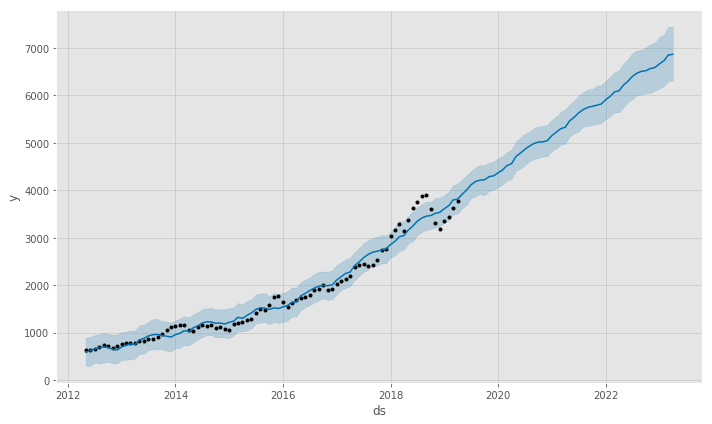

In [61]:
model.plot(forecast, uncertainty=True)
plt.show();

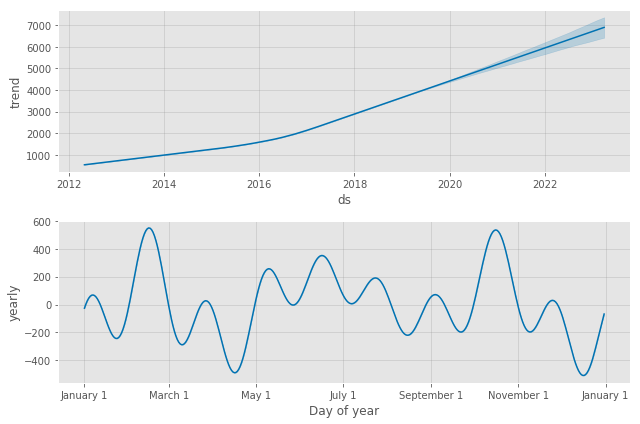

In [62]:
model.plot_components(forecast);